# Getting started on jupyter.nersc.gov
Lets first setup the DESI environment and install the DESI-specific kernel
```bash
source /global/common/software/desi/desi_environment.sh 22.2
${DESIMODULES}/install_jupyter_kernel.sh 22.2
```
See [https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) for more details. 

Now we can import DESI-specific python packages from [desihub](https://github.com/desihub/). 


# Reading DESI spectra
For instance we can use `desispec` to read in some DESI BGS coadded spectra from Comissioning that I've included in the repo

In [1]:
from desispec.io import read_spectra

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
spectra = read_spectra('coadd-66003-20200315-1-00055654.few.fits') # handful of BGS galaxies from Tile 66003 observed on 03/15/2020, Petal #1, Exposure #00055654

INFO:spectra.py:285:read_spectra: iotime 0.120 sec to read coadd-66003-20200315-1-00055654.few.fits at 2022-06-07T07:57:56.310214


(-5.0, 20.0)

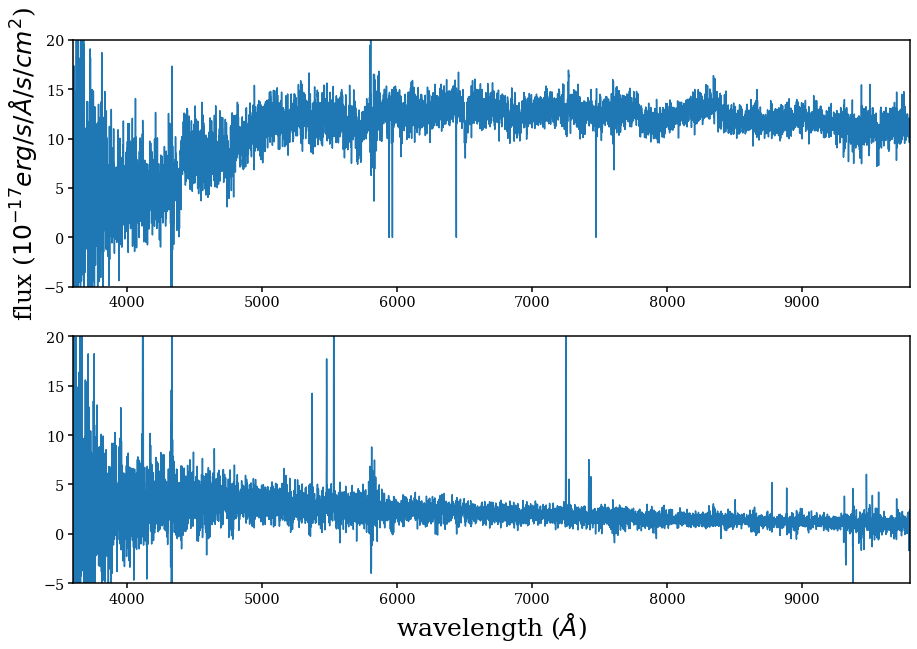

In [4]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(211)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][2])
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux ($10^{-17} erg/s/\AA/s/cm^2$)', fontsize=25)
sub.set_ylim(-5, 20)

sub = fig.add_subplot(212)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][6])
sub.set_xlabel('wavelength ($\AA$)', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)
#sub.set_ylabel('flux ($10^{-17} erg/s/\AA/s/cm^2$)', fontsize=25)
sub.set_ylim(-5, 20)

# Fitting Redshifts using `redrock`
The main goal of DESI is to measure the redshifts of millions of galaxies. Redshifts will be measured for galaxy spectra, like the ones above using `redrock`: https://github.com/desihub/redrock

`redrock` can be easily run on DESI spectra on the command line

In [5]:
f_spec = 'coadd-66003-20200315-1-00055654.few.fits'
f_rr_h5 = 'redrock.coadd.h5'
f_rr = 'zbest.coadd.fits'
print(f_rr)
#!rrdesi -o $f_rr_h5 -z $f_rr -i $f_spec
!rrdesi -o $f_rr -i $f_spec

zbest.coadd.fits
Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
--- Process 0 raised an exception ---
Proc 0: Traceback (most recent call last):
Proc 0:   File "/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock/0.15.4/lib/python3.9/site-packages/redrock/external/desi.py", line 695, in rrdesi
    targets = DistTargetsDESI(args.infiles, coadd=(not args.allspec),
Proc 0:   File "/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock/0.15.4/lib/python3.9/site-packages/redrock/external/desi.py", line 210, in __init__
    assert 'COADD_NUMEXP' not in tmpfmap.dtype.names
Proc 0: AssertionError

Traceback (most recent call last):
  File "/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock/0.15.4/bin/rrdesi", line 9, in <module>
    desi.rrdesi(comm=None)
  File "/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock/0.15.4/lib/python3.9/site-packages/redrock

# `redrock` outputs
Lets take a look at what `redrock` outputs

In [6]:
from astropy.table import Table

In [7]:
zbest = Table.read('zbest.coadd.fits', hdu=1)

FileNotFoundError: [Errno 2] No such file or directory: 'zbest.coadd.fits'

In [8]:
zbest

NameError: name 'zbest' is not defined

In [ ]:
import redrock.templates

In [ ]:
templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

## `redrock` galaxy templates
`redrock` fits galaxy spectra with a linear combination of PCA templates. Here's what the galaxy templates look like:

In [ ]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for i in range(templates[('GALAXY', '')].flux.shape[0]):
    sub.plot(templates[('GALAXY', '')].wave, templates[('GALAXY', '')].flux[i])
sub.set_xlim(templates[('GALAXY', '')].wave.min(), templates[('GALAXY', '')].wave.max())
sub.set_ylim(-0.02, 0.02)

Since the `redrock` output file contains the coefficients of the PCA templates, we can use these templates to reconstruct the best-fit `redrock` fit

In [ ]:
i = 2
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
ncoeff = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

In [ ]:
print('z_redrock = %.3f' % z)

In [ ]:
tflux = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux.T.dot(coeff)
twave = templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].wave * (1+z)

In [ ]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(211)

for band in spectra.bands:
    sub.plot(spectra.wave[band], spectra.flux[band][i], 'C0', alpha=0.5)

for icoeff in range(ncoeff): 
    sub.plot(twave, templates[(zbest['SPECTYPE'][i].strip(), zbest['SUBTYPE'][i].strip())].flux[icoeff] * coeff[icoeff], ls=':', lw=0.5)
sub.plot(twave, tflux, 'r-')
sub.set_ylim(-5, 40)
sub.set_xlim(3500, 10000)

For more details on the redrock output check out the following tutorials: 
- https://github.com/desihub/tutorials/blob/master/redrock/RedrockOutputs.ipynb
- https://github.com/desihub/tutorials/blob/master/redrock/RedrockPlotSpec.md